# 1. Install Dependencies and Setup

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, ReLU, MaxPool2D, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


import cv2

import os
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imghdr
from struct import unpack

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [3]:
data_dir = 'data' 

In [4]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break   

bads = []
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            bads.append(image_path)  

print(len(bads))

# for name in bads:
#     os.remove(os.path.join(name))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

0


In [5]:
image_exts = ['jpeg','jpg', 'png']


for image_class in tqdm(os.listdir(data_dir)): 
# for image_class in os.listdir(data_dir): 
    print(image_class)
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
    # for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)

        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

  0%|          | 0/2 [00:00<?, ?it/s]

happy


  0%|          | 0/153 [00:00<?, ?it/s]

sad


  0%|          | 0/152 [00:00<?, ?it/s]

# 3. Load Data

In [3]:
data = tf.keras.utils.image_dataset_from_directory('TempData', batch_size = 32, label_mode='categorical', image_size=(224,224))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


Found 2901 files belonging to 4 classes.


c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


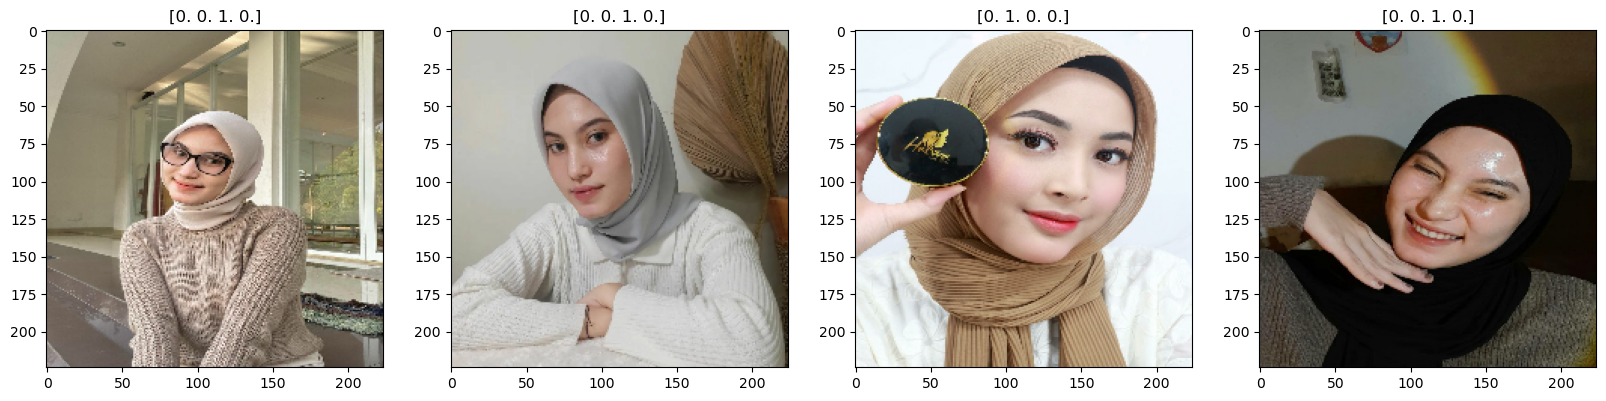

In [4]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [5]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()


(array([[[[0.84313726, 0.70980394, 0.7019608 ],
          [0.8392157 , 0.7058824 , 0.69803923],
          [0.84313726, 0.70980394, 0.7019608 ],
          ...,
          [0.14117648, 0.11372549, 0.14117648],
          [0.14117648, 0.11372549, 0.14117648],
          [0.14117648, 0.11372549, 0.14117648]],
 
         [[0.84247196, 0.70913863, 0.7012955 ],
          [0.8372899 , 0.70395654, 0.6961134 ],
          [0.84313726, 0.70980394, 0.7019608 ],
          ...,
          [0.14509805, 0.11764706, 0.14509805],
          [0.14509805, 0.11764706, 0.14509805],
          [0.14509805, 0.11764706, 0.14509805]],
 
         [[0.84181505, 0.709445  , 0.69859034],
          [0.8372899 , 0.706065  , 0.6915441 ],
          [0.8424195 , 0.71246696, 0.6938726 ],
          ...,
          [0.14509805, 0.11764706, 0.14509805],
          [0.14509805, 0.11764706, 0.14509805],
          [0.14438024, 0.11692928, 0.14438024]],
 
         ...,
 
         [[0.62852806, 0.59323394, 0.6128418 ],
          [0.59444

# 5. Split Data

In [6]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

63
18
9


# 6. Build Deep Learning Model

In [18]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))

model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate = 0.001)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [11]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(224,224,3)))
model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.9))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())


model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.75))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate = 0.001)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      4

In [74]:
# model = Sequential()

# model.add(Conv2D(128, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same',  input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# # model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# # model.add(MaxPooling2D())
# # model.add(Dropout(0.4))
# # model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.2))

# model.add(Dense(4, activation='softmax'))

# opt = Adam(learning_rate = 0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 dropout_119 (Dropout)       (None, 128, 128, 128)     0         
                                                                 
 batch_normalization_74 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 conv2d_75 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 64, 64, 64)     

In [7]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.8))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate = 0.0001)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     1

# 7. Train

In [8]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
63/63 [==============================] - 20s 248ms/step - loss: 2.2446 - accuracy: 0.3973 - val_loss: 2.1090 - val_accuracy: 0.3542
Epoch 2/20
63/63 [==============================] - 14s 218ms/step - loss: 1.7974 - accuracy: 0.5585 - val_loss: 2.0990 - val_accuracy: 0.4358
Epoch 3/20
63/63 [==============================] - 15s 223ms/step - loss: 1.6788 - accuracy: 0.6200 - val_loss: 2.0942 - val_accuracy: 0.4045
Epoch 4/20
63/63 [==============================] - 13s 202ms/step - loss: 1.5337 - accuracy: 0.6796 - val_loss: 2.0755 - val_accuracy: 0.3958
Epoch 5/20
63/63 [==============================] - 17s 266ms/step - loss: 1.4660 - accuracy: 0.6984 - val_loss: 1.8124 - val_accuracy: 0.5521
Epoch 6/20
63/63 [==============================] - 17s 264ms/step - loss: 1.4089 - accuracy: 0.7302 - val_loss: 1.7771 - val_accuracy: 0.5330
Epoch 7/20
63/63 [==============================] - 13s 195ms/step - loss: 1.3463 - accuracy: 0.7584 - val_loss: 1.5928 - val_accuracy: 0.6510

# 8. Plot Performance

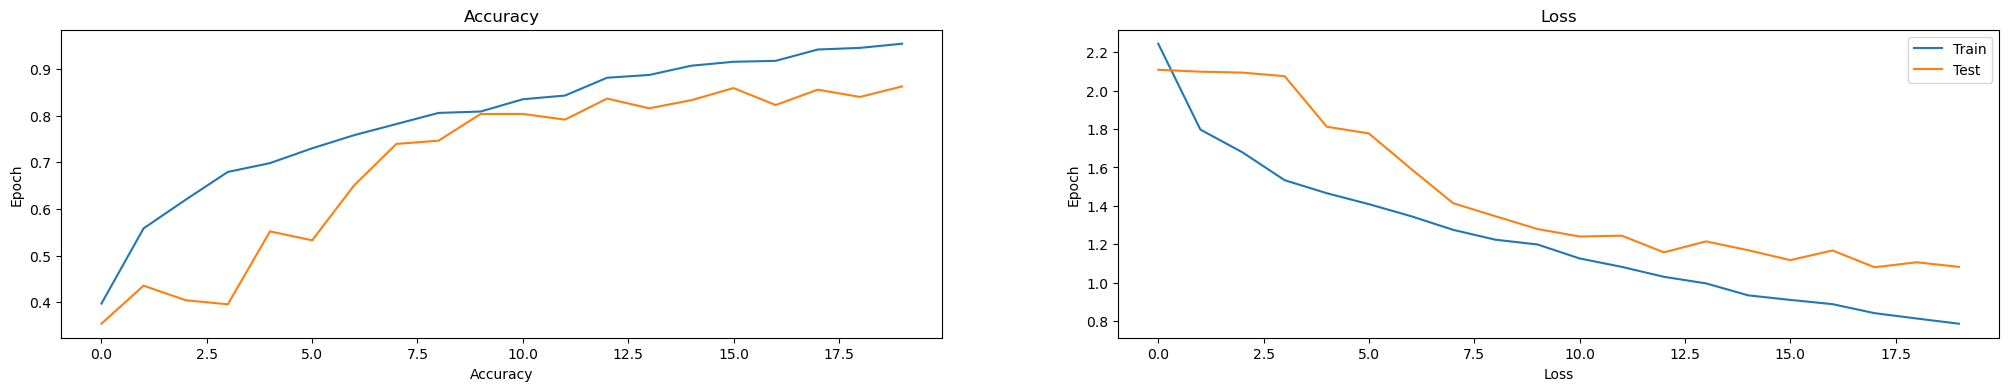

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 9. Evaluate

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision : {(pre.result().numpy())}")
print(f"Recall : {re.result().numpy()}")
print(f"Binary Accuracy : {acc.result().numpy()}")


1/1 [==============================] - 0s 19ms/step
Precision : 0.8357664346694946
Recall : 0.7951388955116272
Binary Accuracy : 0.9097222089767456


# 10. Test

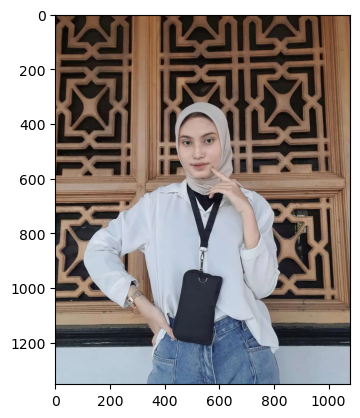

In [67]:
img_load = cv2.imread('TestImages/2021-08-18_12-42-27_UTC_2.jpg')
img = cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

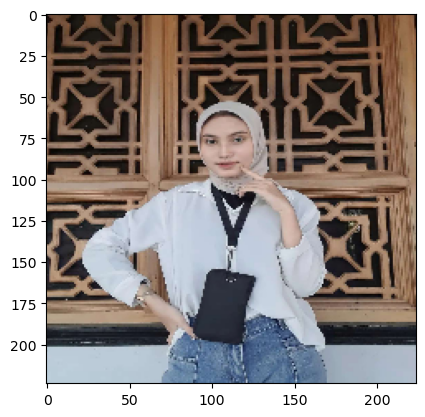

In [68]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [69]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
pred = yhat.argmax()

if pred == 0 :
    print(f'Predicted class is Alifhia Fitri')
elif pred == 1:
    print(f'Predicted class is Delmira Prabu')
elif pred == 2:
    print(f'Predicted class is Haerakeuuu')
elif pred == 3:
    print(f'Predicted class is Jacquelyn Chandra')

1/1 [==============================] - 0s 22ms/step
[[6.5539710e-02 1.0556944e-03 9.3271786e-01 6.8666856e-04]]
Predicted class is Haerakeuuu


# 11. Save the Model

In [37]:
model.save(os.path.join('models','imageclassifier.h5'))

In [70]:
new_model = load_model('models/imageclassifier.h5')
pred_model = new_model.predict(np.expand_dims(resize/255, 0))
label = pred_model.argmax()

if label == 0 :
    print(f'Predicted class is Alifhia Fitri')
elif label == 1:
    print(f'Predicted class is Delmira Prabu')
elif label == 2:
    print(f'Predicted class is Haerakeuuu')
elif label == 3:
    print(f'Predicted class is Jacquelyn Chandra')

1/1 [==============================] - 0s 81ms/step
Predicted class is Haerakeuuu
